In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
SNIPPET_DIR_PATH = '/home/unnc/Documents/_data/_snippet/'
ORIGIN_DIR_PATH = '/home/unnc/Documents/_data/_original_data/'


TRAIN_NAME = f'train'

TEST_17_NAME = f'test_17_choice_correct'
TEST_18_NAME = f'test_18_choice_correct'
TRAIN_3000_NAME = f'train_3000'

In [3]:
OUTPUT_DIR_PATH = '/home/unnc/Documents/_data/choice_correct/' # QC1 QC2 QC3 QC4 QC5
# SWAG_OUTPUT_DIR_PATH = '/home/unnc/Documents/_data/swag/' # Q C1 C2 C3 C4 C5


In [4]:
# original data
# train_original_data = pd.read_excel(f'{ORIGIN_DIR_PATH}train.xlsx', header=None)
test_original_data_17 = pd.read_excel(f'{ORIGIN_DIR_PATH}test_17-18.xlsx', sheet_name='2017', header=None)
test_original_data_18 = pd.read_excel(f'{ORIGIN_DIR_PATH}test_17-18.xlsx', sheet_name='2018', header=None)

## Level 5_3

In [540]:
file_postfix = '4_longTable_tf'
snippet_type = '4_long_tf'
output_dir = f'lvl_{snippet_type}'

In [541]:
# snippet 
# snippet_train = pd.read_excel(f'{SNIPPET_DIR_PATH}/训练集查询结果/带答案搜索/level{file_postfix}.xlsx', header=None)
snippet_test_17 = pd.read_excel(f'{SNIPPET_DIR_PATH}/2017真题查询结果/带答案搜索/indexLevels{file_postfix}.xlsx', header=None)
snippet_test_18 = pd.read_excel(f'{SNIPPET_DIR_PATH}/2018真题查询结果/带答案搜索/indexLevels{file_postfix}.xlsx', header=None)

In [542]:
# concatenate orginal data with snippet
# train_with_snippet = pd.concat([train_original_data, snippet_train], axis=1)
test_17_all = pd.concat([test_original_data_17, snippet_test_17], axis=1)
test_18_all = pd.concat([test_original_data_18, snippet_test_18], axis=1)

# Data cleaning

### drop corruped data

In [543]:
# 1. handle corrupted row at 10040
# if train_with_snippet[train_with_snippet.iloc[:,8].isnull() != True].iloc[:,0].tolist() != []:
#     print(train_with_snippet[train_with_snippet.iloc[:,8].isnull() != True].iloc[:,0].tolist())
#     train_with_snippet.drop(train_with_snippet.index[10040], inplace=True)

In [544]:
# 2. handle wrong choice (longer than 400) at 21511
# if len(train_with_snippet.iloc[21509,2]) > 400:
#     print(train_with_snippet.iloc[21509,2])
#     train_with_snippet.drop(train_with_snippet.index[21509], inplace=True)
#     print('dropped')

### drop nan entries

In [545]:
# 0: question
# 1: question type
# 2-6: choices
# 7: answer
# 10: textbook snippet
# 11-14: title level 1-4
# train_data = train_with_snippet.iloc[:,[0,1,2,3,4,5,6,7,10,11,12,13,14]]

In [546]:
# train_with_snippet.head(1)

In [547]:
# 0: question
# 1: question type
# 2-6: choices
# 7: answer
# 8: textbook snippet: best
# 9-14: title level 1-4
test_17_data = test_17_all.iloc[:,[0,1,2,3,4,5,6,7, 8, 9,10,11,12,13]]
test_18_data = test_18_all.iloc[:,[0,1,2,3,4,5,6,7, 8, 9,10,11,12,13]]

In [548]:
test_17_data.head(1)

,0,1,2,3,4,5,6,7,8,0,1,2,3,4
0,最有助于诊断室性心动过速的心电图特点是,T波和主波方向相反,心室夺获,QRS波群宽大畸形,QRS波群呈束支传导阻滞图形,PR间期延长,A1,2017,2,(1)加速性心室自主节律也称缓慢型室速。心电图表现为：①连续发生3～lO个起源于心室的QRS...,内科学,心律失常,心动过速,特殊类型的室性心动过速


In [549]:
# drop entries that has any nan and, 
# print num of nan in each col
def any_nan_values(df):
    return df.isnull().values.any()

def drop_nan(df):
    if any_nan_values(df):
        print("nan in each col:\n", df.isnull().sum(), sep='')
        
        return df.dropna()
    return df

In [550]:
# train_data = drop_nan(train_data)
# # reset index after dropping rows
# train_data.reset_index(inplace=True)
# train_data = train_data.drop(columns='index')

In [551]:
# assert every cell is not nan
# assert not any_nan_values(train_data) 
assert not any_nan_values(test_17_data) and not any_nan_values(test_18_data)

In [552]:
# train_data.shape

### add column headers

In [553]:
# train_data.columns = ['q', 'q_type', 'c1', 'c2', 'c3', 'c4', 'c5', 'a', 's1', 's1t1', 's1t2', 's1t3', 's1t4']

test_17_data.columns = ['q','c1','c2','c3','c4','c5', 'q_type', 'year', 'a', 's1','s1t1','s1t2','s1t3','s1t4']
test_18_data.columns = ['q','c1','c2','c3','c4','c5', 'q_type', 'year', 'a', 's1','s1t1','s1t2','s1t3','s1t4']

In [554]:
# train_data.head(1)

In [555]:
# rearange df columns to match the ones in training data
# test_17_data = test_17_data[train_data.columns]
# test_18_data = test_18_data[train_data.columns]

In [556]:
# Draw question len && snippet len graph 
def draw_q_s_len(df):
    q_len = [len(str(i).replace(' ', '')) for i in df['q']]
    s1_len = [len(str(i).replace(' ', '')) for i in df['s1']]

    len_512 = round(sum([i > 512 for i in s1_len]) / len(s1_len), 2)
    len_756 = round(sum([i > 756 for i in s1_len]) / len(s1_len), 2)
    len_1024 = round(sum([i > 1024 for i in s1_len]) / len(s1_len), 2)

    label = f'snippet:   >512: {len_512}       >756: {len_756}      >1024: {len_1024}'

    a = sns.distplot(s1_len, kde=False, axlabel=label)
    a = sns.distplot(q_len, kde=False)
    a = a.get_figure()
    a.savefig(f'/{TRUNC_OUTPUT_DIR_PATH}/{output_dir}/qs.png', dpi=120, bbox_inches='tight')
    print('saved to:', TRUNC_OUTPUT_DIR_PATH)

In [557]:
# draw_q_s_len(train_data)

# Add textbook snippit - only the best match

In [558]:
def combine_titles(df_titles):
    """
    df_titles: any cleaned df that contains title information 
    
    return: list
    """
    return [' '.join(titles) for titles in df_titles[['s1t1', 's1t2', 's1t3', 's1t4']].values]


def combine_qst(df_data, add_q=True, add_s=True, add_t=True):
    """
    return: list
    
    output sequence is [title + question + snippet]
    """
    result = []
    if add_t:
        t = combine_titles(df_data)
    q = df_data['q'].values
    s1 = df_data['s1'].values
    
    for i in range(df_data.shape[0]):
        assert 'æ' not in t[i] and 'æ' not in q[i] and 'æ' not in s1[i], 'Input data contains æ sign'
        all_tqs = [t[i], q[i], s1[i]] # change output sequence here
        input_tqs = [] 
        for i, add in enumerate([add_t, add_q, add_s]): # should be the same sequence as all_tqs
            if add:
                input_tqs.append(all_tqs[i])
        input_row = '  æ  '.join(input_tqs)
        result.append(input_row)
    print(f'First output is \n{result[0]}')
    return result

In [559]:
def get_trunc_df(df_data):
    qst_list = combine_qst(df_data, True, True, True)
    df_trunc = df_data[['q','q_type','c1','c2','c3','c4','c5','a']].copy()
    df_trunc['q'] = qst_list
    return df_trunc
def add_question_index(df_data):
    question_len = df_data.shape[0]
    df_data['q_index'] = range(question_len)
    return df_data

In [560]:
# train_trunc = get_trunc_df(train_data)
# train_trunc = add_question_index(train_trunc)

In [561]:
test_17_trunc = get_trunc_df(test_17_data)
test_17_trunc = add_question_index(test_17_trunc)

First output is 
内科学 心律失常 心动过速 特殊类型的室性心动过速  æ  最有助于诊断室性心动过速的心电图特点是  æ  (1)加速性心室自主节律也称缓慢型室速。心电图表现为：①连续发生3～lO个起源于心室的QRS波群，心率常为60～110次／分。②心动过速的开始和终止呈渐进性。③由于心室与窦房结两个起搏点轮流控制心室节律，融合波常出现于心律失常的开始与终止时，心室夺获亦很常见。(2)尖端扭转型室速尖端扭转是多形性室性心动过速的一个特殊类型，因发作时QRS波群的振幅与波峰呈周期性改变，宛如围绕等电位线连续扭转而得名。频率200～250次／分。QT间期>0．5S U波显著。治疗：①静脉注射硫酸镁可终止和预防尖端扭转型室速的发作；②I A类、Ⅲ类药物均可使QT间期延长，不宜使用；I B类药物(利多卡因、苯妥英钠)对本病无效。


In [562]:
test_18_trunc = get_trunc_df(test_18_data)
test_18_trunc = add_question_index(test_18_trunc)
assert test_18_trunc.shape[0] == 599 and test_17_trunc.shape[0] == 600

First output is 
外科学 前列腺炎、附睾炎与肾结核 肾结核 诊断  æ  要了解肾结核患者分侧肾功能、病变程度与范围。首选的方法是  æ  (1)尿液抗酸杆菌尿沉渣涂片抗酸染色约50％～70％的病例可找到抗酸杆菌。但找到抗酸杆菌不能作为诊断的唯一依据，因枯草杆菌、包皮垢杆菌也是抗酸杆菌。(2)尿液结核杆菌培养阳性率可达90％，对诊断有决定性意义，但需时较长(4～8周)。(3)尿路平片(KUB)  可见到病肾局灶或斑点状钙化影或全肾广泛钙化。(4)静脉尿路造影(IVU)  可了解分肾功能、病变程度和范围，是确诊肾结核的检查方法，对肾结核治疗方案的选择必不可少。早期表现为肾盏边缘不光滑如虫蛀状，随着病变进展，肾盏失去杯形，不规则扩大或模糊变形。若肾盏颈纤维化狭窄，可见空洞充盈不全或完全不显影。肾脏广泛被破坏、肾功能丧失时，不能显示出典型的结核破坏性病变。根据临床表现，如尿中找到结核杆菌，静脉尿路造影一侧肾正常，另一侧“无功能”未显影，可确诊肾结核。(5)逆行肾孟造影可显示病肾空洞性破坏，输尿管僵硬，管腔节段性狭窄且边缘不整。(6)B超简单易行，对中晚期病例可初步确定病变部位，较易发现对侧肾积水及膀胱挛缩。(7)CT和MRI CT对中晚期肾结核能清楚显示扩大的肾盏肾盂、皮质空洞及钙化灶，三维成像还可显示输尿管全长病变。MRI水成像对诊断肾结核。肾积水有独到之处。(8)膀胱镜检查病变以膀胱三角区和患侧输尿管口周围最明显。当膀胱挛缩容量<50ml、有急性膀胱炎时禁忌检查。注意：①对肾结核最有价值的确诊方法是_一尿液结核杆菌培养，但少用；其次为静脉尿路造影(IVU)。


In [563]:
def draw_input_len(df):
    input_len = [len(i.replace(' ', '')) for i in df['q']]
    len_512 = round(sum([i > 512 for i in input_len]) / len(input_len), 2)
    len_756 = round(sum([i > 756 for i in input_len]) / len(input_len), 2)
    len_1024 = round(sum([i > 1024 for i in input_len]) / len(input_len), 2)

    label = f'test_18_only_correct: >512: {len_512}       >756: {len_756}      >1024: {len_1024}'
    a = sns.distplot(input_len, kde=False, axlabel=label)
    a = a.get_figure()
    a.savefig(f'/{OUTPUT_DIR_PATH}/{output_dir}/only_correct_18.png', dpi=120, bbox_inches='tight')

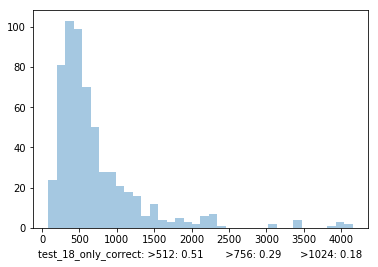

In [564]:
draw_input_len(test_18_trunc)

In [565]:
def shuffle_df(df, frac=1, random_state=42):
    return df.sample(frac=frac, random_state=random_state)

In [566]:
# train_trunc_shuffled = shuffle_df(train_trunc)

In [567]:
# train_trunc_shuffled.head(1)

# 1. TRUNC method

For a single question

$QC_1...C_5 \longrightarrow \sum_{c=1}^{5} QC_c$

question + 5 choice -> 5 * (question + 1 choice)

In [568]:
def expand_choices(df):
    """
    return:
    df with expanded choice
    """
    
    result = []
    question_index = df.columns.get_loc('q')
    first_choice_index = df.columns.get_loc('c1')
    answer_index = df.columns.get_loc('a')
    # iterate through all entries in df
    for i in tqdm(range(df.shape[0])):
        one_entry = df.iloc[i,:] 
        # for each entry, take its 5 choices in sequence into 5 [question, one_choice, label] outputs
        for choice_index in range(5):
            label = 1 if (choice_index + 1)  == one_entry[answer_index] else 0
            result.append({'input': one_entry[question_index], 
                       'choice': one_entry[first_choice_index+choice_index],
                       'q_type': one_entry['q_type'],
                       'c_index': choice_index, 
                       'q_index': one_entry['q_index'],
                       'label': label})
    return pd.DataFrame(result)[['input','q_index','choice','c_index','label','q_type']]

In [569]:
# train_trunc_df = expand_choices(train_trunc_shuffled)

In [570]:
test_17_trunc_df = expand_choices(test_17_trunc)

In [571]:
test_18_trunc_df = expand_choices(test_18_trunc)

### Save files to help calculating accuracy

In [572]:
def save_debug_file(df, file_name):
    df.to_excel(f'{TRUNC_OUTPUT_DIR_PATH}/{output_dir}/{file_name}_debug.xlsx', index=None)
    print(f'{file_name} saved!')

In [573]:
# save_debug_file(test_17_trunc_df, TEST_17_NAME)
# save_debug_file(test_18_trunc_df, TEST_18_NAME)
# save_debug_file(train_trunc_df.head(15000), TRAIN_3000_NAME)

### Preparing for bert

In [574]:
def prepare_for_bert(df):
    return pd.DataFrame({
        'id':range(df.shape[0]),
        'label':df['label'],
        'alpha':['a']*df.shape[0],
        'text_a': df['input'].replace(r'\n', ' ', regex=True),
        'text_b': df['choice'].replace(r'\n', ' ', regex=True)
    })

In [575]:
# train_trunc_bert = prepare_for_bert(train_trunc_df)

test_17_trunc_bert = prepare_for_bert(test_17_trunc_df)
test_18_trunc_bert = prepare_for_bert(test_18_trunc_df)
# train_3000_trunc_bert = prepare_for_bert(train_trunc_df.head(15000))

In [576]:
def save_input_file(df_bert, file_name):
    df_bert.to_csv(f'{OUTPUT_DIR_PATH}/{output_dir}/{file_name}.tsv', 
                sep='\t', index=False, header=False)
    print(f'{file_name} saved!')

In [577]:
# save_input_file(train_trunc_bert, TRAIN_NAME)

In [578]:
save_input_file(test_17_trunc_bert, TEST_17_NAME)
save_input_file(test_18_trunc_bert, TEST_18_NAME)
# save_input_file(train_3000_trunc_bert, TRAIN_3000_NAME)

test_17_choice_correct saved!
test_18_choice_correct saved!
